In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [4]:
data = pd.read_csv("cm_dataset.csv")
x, y = np.array(data.iloc[:, 0].values, dtype='float64'), np.array(data.iloc[:, 1].values, dtype='float64')
points = np.array([[x[i], y[i]] for i in range(len(x))]).T

num_points = len(x)
dimensions = 2
iterations = 20
num_clusters = 2
distant_point = np.array([1e9, 1e9])

In [5]:
def calculate_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2)**2))

def kernelise(data, d):
    kernelised_matrix = np.array([[(1+np.dot(data[:, i], data[:, j]))**d for i in range(data.shape[1])]for j in range(data.shape[1])])

    return kernelised_matrix

def kernelise_rad(data, d):
    kernelised_matrix = np.zeros((num_points, num_points))
    for i in range(num_points):
        for j in range(num_points):
            diff = data[:, i] - data[:, j]
            kernelised_matrix[i, j] = np.exp(-(np.dot(diff, diff)/(2*(d**2))))

    return kernelised_matrix

def center_kernel(kernel_matrix):
    n = kernel_matrix.shape[0]
    one_n = np.ones((n,n))
    one_n /= n
    centered_kernel_matrix = kernel_matrix - np.dot(one_n, kernel_matrix) - np.dot(kernel_matrix, one_n) + np.dot(np.dot(one_n, kernel_matrix), one_n)
    epsilon = 5*1e-7
    centered_kernel_matrix += epsilon*np.eye(n)

    return centered_kernel_matrix

In [63]:
powers = np.array([2, 3, 4, 5, 8, 10, 15, 25, 50])
poly_kernelised_data = np.zeros((powers.shape[0], num_points, num_points), dtype='float64')
centered_poly_kernelised_data = np.zeros((powers.shape[0], num_points, num_points), dtype='float64')

for i, power in enumerate(powers):
    poly_kernelised_data[i] = kernelise(points, power)
    centered_poly_kernelised_data[i] = center_kernel(poly_kernelised_data[i])

eigen_values_poly = []
eigen_vectors_poly = []
for cpkd in centered_poly_kernelised_data:
    eigen_vals, eigen_vecs = np.linalg.eig(cpkd)[0].real, np.linalg.eig(cpkd)[1].real 
    descending_values = np.argsort(eigen_vals)[::-1]
    eigen_vals = eigen_vals[descending_values]
    eigen_vecs = eigen_vecs[:, descending_values]
    eigen_values_poly.append(eigen_vals)
    eigen_vectors_poly.append(eigen_vecs)

eigen_values_poly = np.array(eigen_values_poly)
eigen_vectors_poly = np.array(eigen_vectors_poly)

z_poly = np.zeros((powers.shape[0], num_points), dtype='int')
for i, eigen_vecs in enumerate(eigen_vectors_poly):
    for j in range(num_points):
        z_poly[i, j] = np.argmax(eigen_vecs[j, :num_clusters])


poly_clusters = []
for r in range(powers.shape[0]):
    clusters = [[[], []] for i in range(num_clusters)]
    for i, z1 in enumerate(z_poly[r]):
        for j in range(dimensions):
            clusters[z1][j].append(points[j, i])

    poly_clusters.append(clusters)

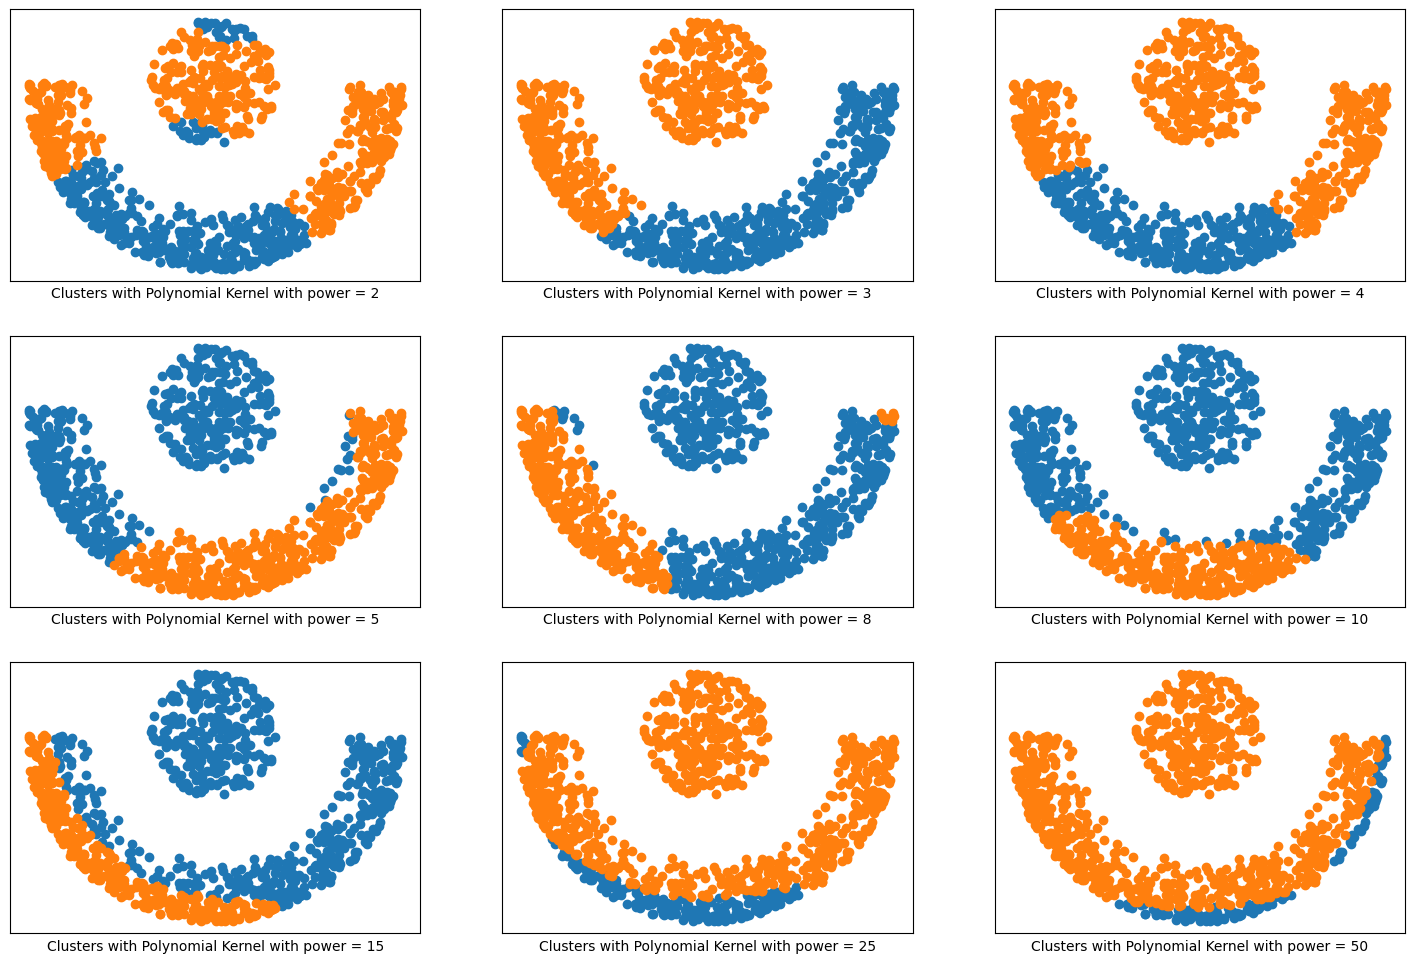

In [67]:
rows = powers.shape[0]//3
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*4))
if rows > 1:
    for i in range(rows):
        for j in range(cols):
            for cluster in poly_clusters[cols*i+j]:
                axes[i][j].scatter(cluster[0], cluster[1])
                axes[i][j].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
                axes[i][j].set_xlabel("Clusters with Polynomial Kernel with power = " + str(powers[cols*i+j]))
else:
    for j in range(cols):
            for cluster in poly_clusters[j]:
                axes[j].scatter(cluster[0], cluster[1])
                axes[j].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
                axes[j].set_xlabel("Clusters with Polynomial Kernel with power = " + str(powers[j]))

plt.savefig('images/Q1/p4poly')
plt.show()

In [65]:
sigmas = np.array([10**i for i in range(-1, 5)])
rad_kernelised_data = np.zeros((sigmas.shape[0], num_points, num_points), dtype='float64')
centered_rad_kernelised_data = np.zeros((sigmas.shape[0], num_points, num_points), dtype='float64')

for i, sigma in enumerate(sigmas):
    rad_kernelised_data[i] = kernelise_rad(points, sigma)
    centered_rad_kernelised_data[i] = center_kernel(rad_kernelised_data[i])


eigen_values_rad = []
eigen_vectors_rad = []
for crkd in centered_rad_kernelised_data:
    eigen_vals, eigen_vecs = np.linalg.eig(crkd)[0].real, np.linalg.eig(crkd)[1].real 
    descending_values = np.argsort(eigen_vals)[::-1]
    eigen_vals = eigen_vals[descending_values]
    eigen_vecs = eigen_vecs[:, descending_values]
    eigen_values_rad.append(eigen_vals)
    eigen_vectors_rad.append(eigen_vecs)

eigen_values_rad = np.array(eigen_values_rad)
eigen_vectors_rad = np.array(eigen_vectors_rad)

z_rad = np.zeros((sigmas.shape[0], num_points), dtype='int')
for i, eigen_vecs in enumerate(eigen_vectors_rad):
    for j in range(num_points):
        z_rad[i, j] = np.argmax(abs(eigen_vecs[j, :num_clusters]))


rad_clusters = []
for r in range(sigmas.shape[0]):
    clusters = [[[], []] for i in range(num_clusters)]
    for i, z1 in enumerate(z_rad[r]):
        for j in range(dimensions):
            clusters[z1][j].append(points[j, i])
    
    rad_clusters.append(clusters)

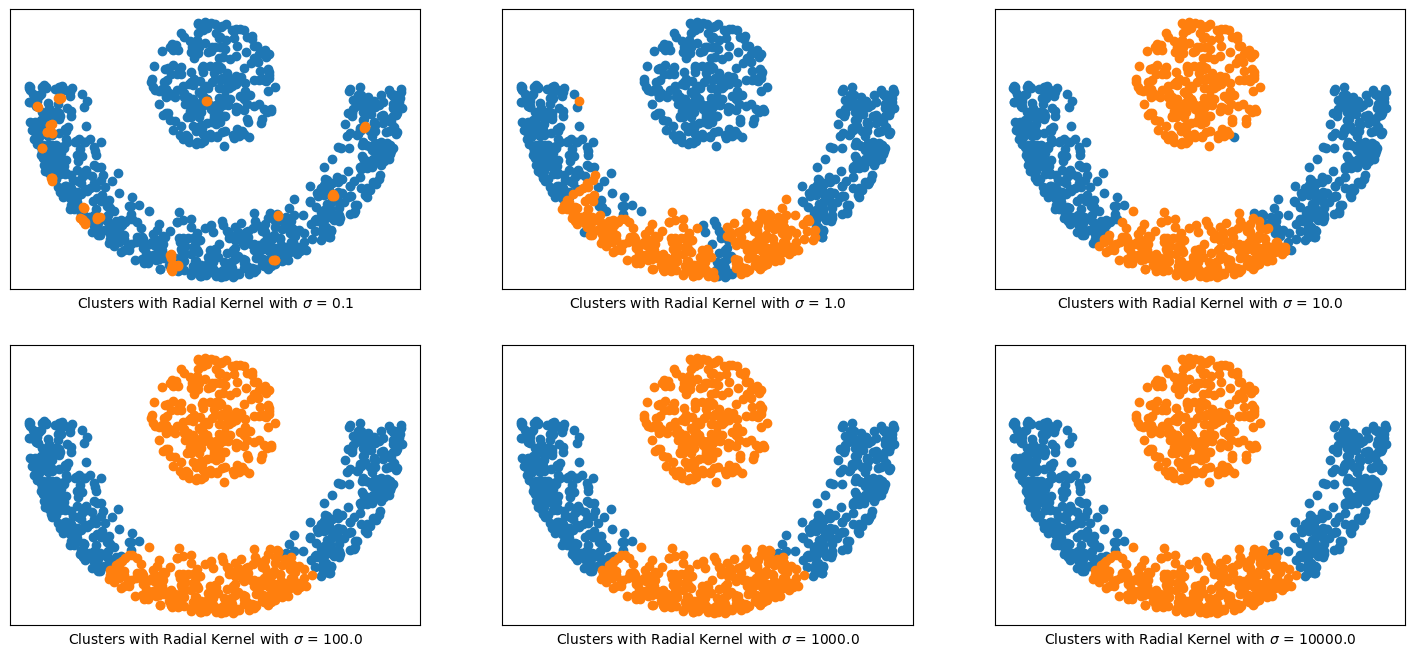

In [68]:
rows = sigmas.shape[0]//3
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*4))
if rows > 1:
    for i in range(rows):
        for j in range(cols):
            for cluster in rad_clusters[cols*i+j]:
                axes[i][j].scatter(cluster[0], cluster[1])
                axes[i][j].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
                axes[i][j].set_xlabel(r"Clusters with Radial Kernel with $\sigma$ = " + str(sigmas[cols*i+j]))
else:
    for j in range(cols):
            for cluster in rad_clusters[j]:
                axes[j].scatter(cluster[0], cluster[1])
                axes[j].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
                axes[j].set_xlabel(r"Clusters with Radial Kernel with $\sigma$ = " + str(sigmas[j]))

plt.savefig('images/Q1/p4rad')
plt.show()